<a href="https://colab.research.google.com/github/antbartash/australian_rain/blob/main/Grid_Random_HalvingSearchCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
)
from scipy.stats import uniform, randint
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [3]:
data = pd.read_csv(
    'https://raw.githubusercontent.com/antbartash/australian_rain/main/data/data_transformed.csv',
    index_col=0
  )

print(data.shape)
data.head()

(142193, 23)


,Location,WindGustDir,WindDir9am,WindDir3pm,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month
0,2.0,13.0,13.0,14.0,13.4,22.9,0.6,NaN,NaN,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0.0,12.0
1,2.0,14.0,6.0,15.0,7.4,25.1,0.0,NaN,NaN,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0.0,12.0
2,2.0,15.0,13.0,15.0,12.9,25.7,0.0,NaN,NaN,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0.0,12.0
3,2.0,4.0,9.0,0.0,9.2,28.0,0.0,NaN,NaN,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,0.0,12.0
4,2.0,13.0,1.0,7.0,17.5,32.3,1.0,NaN,NaN,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0.0,12.0


In [4]:
X, y = data.drop(columns=['RainTomorrow', 'RainToday']), data['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [5]:
def change_dtypes(data):
  for column in ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']:
    data[column] = data[column].astype('category')
  return data

X_train = change_dtypes(X_train)
X_test = change_dtypes(X_test)

X_train.dtypes

Location         category
WindGustDir      category
WindDir9am       category
WindDir3pm       category
MinTemp           float64
MaxTemp           float64
Rainfall          float64
Evaporation       float64
Sunshine          float64
WindGustSpeed     float64
WindSpeed9am      float64
WindSpeed3pm      float64
Humidity9am       float64
Humidity3pm       float64
Pressure9am       float64
Pressure3pm       float64
Cloud9am          float64
Cloud3pm          float64
Temp9am           float64
Temp3pm           float64
Month             float64
dtype: object

# Baseline model

In [ ]:
baseline_lgbm = LGBMClassifier(random_state=42, verbose=0)
cv_result = cross_validate(baseline_lgbm, X, y, scoring='roc_auc',
                           return_train_score=True)

print(f"Mean train Gini: {cv_result['train_score'].mean() * 2 - 1}")
print(f"Mean test Gini: {cv_result['test_score'].mean() * 2 - 1}")
print(f"Mean fit time: {np.round(cv_result['fit_time'].mean(), 2)} s")

Mean train Gini: 0.8193700395010979
Mean test Gini: 0.7007491769077299
Mean fit time: 2.24 s


# GridSearchCV

In [ ]:
hyperparameter_space = {
    'n_estimators': [100, 250, 500, 1000],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
    'num_leaves': [30],
    'max_depth': [1, 2, 6, -1],
    'class_weight': [None],
    'colsample_bytree': [0.75, 1],
    'reg_alpha': [0, 1, 5],
    'reg_lambda': [0, 1, 5]
}

model = LGBMClassifier(random_state=42, verbose=0)
clf = GridSearchCV(model, hyperparameter_space, cv=3,
                   scoring='roc_auc', verbose=1)
clf.fit(X_train, y_train) # 7 hrs

In [ ]:
print(f"Best Gini: {clf.best_score_ * 2 - 1}")
print(f"Best params: {clf.best_params_}")

Best Gini: 0.8012352188729492
Best params: {'class_weight': None, 'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 1000, 'num_leaves': 30, 'reg_alpha': 5, 'reg_lambda': 5}


# RandomizedSearchCV

In [ ]:
hyperparameter_space = {
    'n_estimators': randint(50, 4000),
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5],
    'num_leaves': randint(3, 250),
    'max_depth': [-1, 1, 2, 3, 4, 6, 8, 10, 20, 30],
    'class_weight': [None, 'balanced'],
    'colsample_bytree': uniform(loc=0.3, scale=0.7),
    'reg_alpha': uniform(0, 50),
    'reg_lambda': uniform(0, 50)
}

model = LGBMClassifier(random_state=42, verbose=0)
clf = RandomizedSearchCV(model, hyperparameter_space, n_iter=50, cv=3,
                         scoring='roc_auc', random_state=42, verbose=0)
clf.fit(X_train, y_train) # 30 min

In [ ]:
print(f"Best Gini: {clf.best_score_ * 2 - 1}")
print(f"Best params: {clf.best_params_}")

Best Gini: 0.800846427444265
Best params: {'class_weight': 'balanced', 'colsample_bytree': 0.4751759523611048, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 3100, 'num_leaves': 190, 'reg_alpha': 16.332562089802042, 'reg_lambda': 41.393450189379436}


# HalvingSearch

## HalvingGridSearchCV: resource='n_samples'

In [10]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV

In [ ]:
hyperparameter_space = {
    'n_estimators': np.arange(100, 4100, 1000),
    'learning_rate': [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3],
    #'num_leaves': [10, 30, 50, 150, 250],
    'max_depth': [-1, 1, 3, 6, 8, 15],
    'class_weight': [None, 'balanced'],
    #'colsample_bytree': [0.5, 0.75, 0.9, 1],
    #'reg_alpha': [0, 10, 25, 40, 50],
    #'reg_lambda': [0, 10, 25, 40, 50]
}

model = LGBMClassifier(random_state=42, verbose=-1)
clf = HalvingGridSearchCV(model, hyperparameter_space, cv=3,
                          scoring='roc_auc', verbose=1, random_state=42,
                          factor=3, resource='n_samples', min_resources=1250)
clf.fit(X_train, y_train) # 72 min
print(f"Best Gini: {clf.best_score_ * 2 - 1}")
print(f"Best params: {clf.best_params_}")

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 1250
max_resources_: 113754
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 336
n_resources: 1250
Fitting 3 folds for each of 336 candidates, totalling 1008 fits
----------
iter: 1
n_candidates: 112
n_resources: 3750
Fitting 3 folds for each of 112 candidates, totalling 336 fits
----------
iter: 2
n_candidates: 38
n_resources: 11250
Fitting 3 folds for each of 38 candidates, totalling 114 fits
----------
iter: 3
n_candidates: 13
n_resources: 33750
Fitting 3 folds for each of 13 candidates, totalling 39 fits
----------
iter: 4
n_candidates: 5
n_resources: 101250
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Gini: 0.7969568417107886
Best params: {'class_weight': None, 'learning_rate': 0.005, 'max_depth': 15, 'n_estimators': 3100}


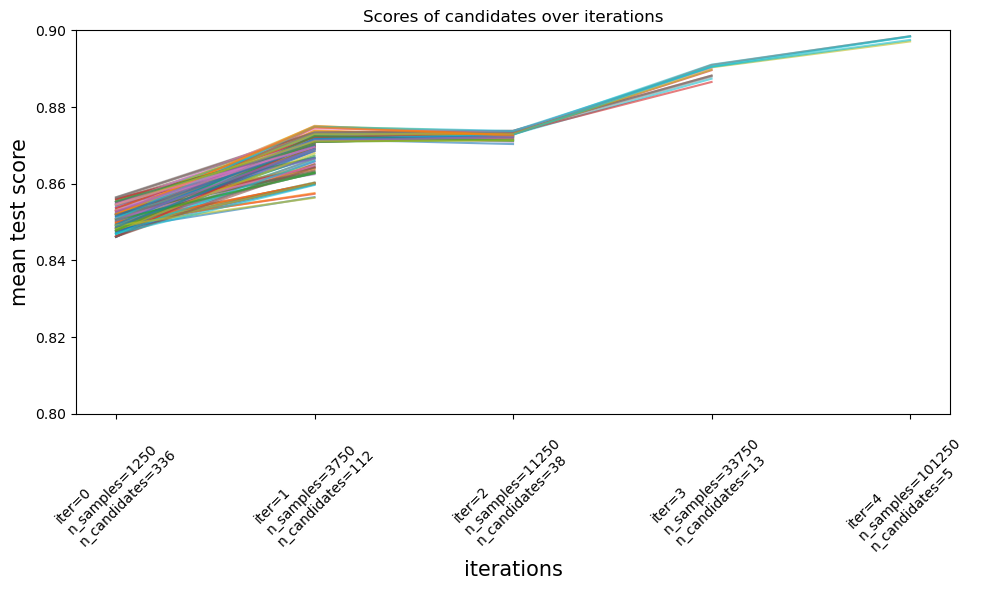

In [ ]:
results = pd.DataFrame(clf.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6, figsize=(10, 6))

labels = [
    f"iter={i}\nn_samples={clf.n_resources_[i]}\nn_candidates={clf.n_candidates_[i]}"
    for i in range(clf.n_iterations_)
]

ax.set_xticks(range(clf.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
ax.set_ylim(0.8, 0.9)
plt.tight_layout()
plt.show()

In [ ]:
hyperparameter_space = {
    'n_estimators': np.arange(100, 4100, 1000),
    'learning_rate': [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3],
    #'num_leaves': [10, 30, 50, 150, 250],
    'max_depth': [-1, 1, 3, 6, 8, 15],
    'class_weight': [None, 'balanced'],
    #'colsample_bytree': [0.5, 0.75, 0.9, 1],
    #'reg_alpha': [0, 10, 25, 40, 50],
    #'reg_lambda': [0, 10, 25, 40, 50]
}

model = LGBMClassifier(random_state=42, verbose=-1)
clf = GridSearchCV(model, hyperparameter_space, cv=3,
                   scoring='roc_auc', verbose=1)
clf.fit(X_train, y_train) # 250 min
print(f"Best Gini: {clf.best_score_ * 2 - 1}")
print(f"Best params: {clf.best_params_}")

Fitting 3 folds for each of 336 candidates, totalling 1008 fits
Best Gini: 0.8028389136012513
Best params: {'class_weight': None, 'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 3100}


In [ ]:
# HalvingGridSeachCV
# Best Gini: 0.7969568417107886
# Best params: {'class_weight': None, 'learning_rate': 0.005, 'max_depth': 15, 'n_estimators': 3100}

## HalvingGridSearchCV: resouce='n_estimators'

In [6]:
def get_catboost_dataset(data):
    data_catboost = data.copy()
    for column in ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']:
        data_catboost[column] = data_catboost[column].astype(np.float32).fillna(-1).apply(lambda x: str(x))
    return data_catboost

X_train_catboost, X_test_catboost = get_catboost_dataset(X_train), get_catboost_dataset(X_test)

In [7]:
baseline_catboost = CatBoostClassifier(
    n_estimators=250,
    cat_features=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'],
    random_state=42, verbose=50, task_type='GPU'
)
baseline_catboost.fit(X_train_catboost, y_train)

Learning rate set to 0.089979
0:	learn: 0.6327238	total: 36.2ms	remaining: 9.02s
50:	learn: 0.3453624	total: 1.15s	remaining: 4.47s
100:	learn: 0.3299305	total: 2.15s	remaining: 3.18s
150:	learn: 0.3214348	total: 3.17s	remaining: 2.08s
200:	learn: 0.3151242	total: 5.55s	remaining: 1.35s
249:	learn: 0.3105465	total: 7.36s	remaining: 0us


In [11]:
hyperparameter_space = {
    # 'n_estimators': np.arange(100, 4100, 1000),
    # 'learning_rate': [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3],
    'max_depth': [1, 2, 3, 4, 5, 6, 8, 10, 16],
    'scale_pos_weight': [1, 3, 3.5, 4]
}

model = CatBoostClassifier(
    n_estimators=100,
    cat_features=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'],
    random_state=42, verbose=False, task_type='GPU'
)
clf = HalvingGridSearchCV(
    model, hyperparameter_space, cv=3,
    scoring='roc_auc', verbose=1, random_state=42,
    factor=3, resource='n_estimators',
    min_resources=100, max_resources=5000)
clf.fit(X_train_catboost, y_train)
print(f"Best Gini: {clf.best_score_ * 2 - 1}")
print(f"Best params: {clf.best_params_}")

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 100
max_resources_: 5000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 36
n_resources: 100
Fitting 3 folds for each of 36 candidates, totalling 108 fits
----------
iter: 1
n_candidates: 12
n_resources: 300
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 2
n_candidates: 4
n_resources: 900
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 3
n_candidates: 2
n_resources: 2700
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Gini: 0.8028741201414575
Best params: {'max_depth': 10, 'scale_pos_weight': 1, 'n_estimators': 2700}


In [ ]:
# The get_params() method of the target estimator (CatBoostClassifier) is called to validate that the given resource is valid.
# The CatBoost has the get_params method, however, it returns only params that the user explicitly specified, while sklearn's estimator returns all parameters.

## HalvingRandomSearchCV

In [ ]:
hyperparameter_space = {
    'n_estimators': randint(50, 4000),
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5],
    'num_leaves': randint(3, 250),
    'max_depth': [-1, 1, 2, 3, 4, 6, 8, 10, 20, 30],
    'class_weight': [None, 'balanced'],
    'colsample_bytree': uniform(loc=0.3, scale=0.7),
    'reg_alpha': uniform(0, 50),
    'reg_lambda': uniform(0, 50)
}

model = LGBMClassifier(random_state=42, verbose=-1)
clf = HalvingRandomSearchCV(
    model, hyperparameter_space, cv=3,
    scoring='roc_auc', verbose=1, random_state=42,
    factor=3, resource='n_samples', min_resources=1250)
clf.fit(X_train, y_train) # 30 min
print(f"Best Gini: {clf.best_score_ * 2 - 1}")
print(f"Best params: {clf.best_params_}")

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 1250
max_resources_: 113754
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 91
n_resources: 1250
Fitting 3 folds for each of 91 candidates, totalling 273 fits
